## Importing the Libraries

In [199]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from scipy import stats

### Importing the Dataset

In [200]:
dataset = pd.read_excel('MRT Prediction Database for ICMIME.xlsx')

### Deal with Outliers

In [201]:
# Step 1: Remove Outliers using Z-scores
def remove_outliers_zscore(df, threshold=3):
    z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))  # Only numeric columns
    outliers = (z_scores > threshold).any(axis=1)
    print(f"Number of outliers detected: {outliers.sum()}")
    return df[~outliers]
# Step 2: Apply outlier removal
response_column = 'Globe temperature (°C) [MRT]'  # Replace with the actual target column name in your dataset
dataset_clean = remove_outliers_zscore(dataset)

# Step 3: Dataset is now ready for any machine learning model
print(f"Shape of dataset after cleaning: {dataset_clean.shape}")

Number of outliers detected: 694
Shape of dataset after cleaning: (21033, 4)


### Printing Maximum and Minimum Values of Every Variables

In [202]:
# Print the max and min value of every variable after removing outliers
max_values = dataset_clean.max()  # Maximum values of each column
min_values = dataset_clean.min()  # Minimum values of each column

# Printing the results
print("Maximum values of each variable after removing outliers:")
print(max_values)

print("\nMinimum values of each variable after removing outliers:")
print(min_values)


Maximum values of each variable after removing outliers:
Air temperature (°C)            36.40
Radiant temperature (°C)        36.90
Air velocity (m/s)               0.93
Globe temperature (°C) [MRT]    36.60
dtype: float64

Minimum values of each variable after removing outliers:
Air temperature (°C)            12.2
Radiant temperature (°C)        12.4
Air velocity (m/s)               0.0
Globe temperature (°C) [MRT]    12.4
dtype: float64


### Cleaned Dataset for Training and Testing

In [203]:
X = dataset_clean.iloc[:, :-1]
y = dataset_clean.iloc[:, -1]

## Splitting the Dataset into the Training Set and Test Set

In [204]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

### Feature Scaling: Standardization

In [205]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train) # Compute the mean and std to be used for later scaling.
X_train = sc.transform(X_train) # Perform standardization by centering and scaling.
X_test = sc.transform(X_test) 

### Build the ANN model

In [206]:
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Input(shape=(3,)))
ann.add(tf.keras.layers.Dense(units=128, activation='relu'))
ann.add(tf.keras.layers.Dense(units=128, activation='relu'))
ann.add(tf.keras.layers.Dense(units=128, activation='relu'))
ann.add(tf.keras.layers.Dense(units=1, activation='linear'))

## Compiling the ANN

In [207]:
import keras
ann.compile(optimizer = 'adam', loss = keras.losses.mean_squared_error, metrics = ['mean_absolute_error', 'mean_absolute_percentage_error'])
# ann.compile(optimizer = 'adam', loss = 'mean_absolute_error', metrics = ['mean_squared_error', 'mean_absolute_percentage_error'])
# 'mean_absolute_error', 'mean_absolute_percentage_error'

### Define the Stopping Criteria (loss threshold)

In [208]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # or 'val_loss' if you want to monitor validation loss
    patience=15,     # Number of epochs to wait before stopping
    min_delta=0.000001, # an absolute change of less than min_delta, will count as no improvement
    mode='min',      # Stop when the monitored quantity stops decreasing
    verbose=1
)

### Saving the Weights with the Minimum Loss

In [209]:
weights_of_min_loss = tf.keras.callbacks.ModelCheckpoint(
    'best_weights.keras',      # File path where the weights will be saved
    monitor='loss',         # Monitor the loss value
    save_best_only=True,     # Save only the weights with the best (minimum) loss
    mode='min',             # Mode 'min' indicates that we want to save when loss is minimized
    verbose=1               # Print out information about the saving process
)

## Training the ANN on the Training Set

In [210]:
history = ann.fit(X_train, y_train, batch_size = 32, epochs = 1000, callbacks=[early_stopping, weights_of_min_loss], validation_data=(X_test, y_test), verbose=1)

Epoch 1/1000
518/526 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - loss: 151.2574 - mean_absolute_error: 8.1853 - mean_absolute_percentage_error: 33.9857
Epoch 1: loss improved from inf to 44.79426, saving model to best_weights.keras
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 149.4436 - mean_absolute_error: 8.0983 - mean_absolute_percentage_error: 33.6276 - val_loss: 0.3318 - val_mean_absolute_error: 0.2561 - val_mean_absolute_percentage_error: 1.0879
Epoch 2/1000
491/526 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - loss: 0.2045 - mean_absolute_error: 0.2292 - mean_absolute_percentage_error: 0.9615
Epoch 2: loss improved from 44.79426 to 0.13062, saving model to best_weights.keras
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1997 - mean_absolute_error: 0.2269 - mean_absolute_percentage_error: 0.9517 - val_loss: 0.1012 - val_mean_absolute_error: 0.1468 - val_mean_absolute_percentage_error: 0.6070
Epoch 3/1000
508/526 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - loss: 0.0608 - mean_absolute_error: 0.

## Plot the Training and Validation Loss Values

[44.79426193237305, 0.13061507046222687, 0.06662171334028244, 0.05789279565215111, 0.0514550618827343, 0.050261516124010086, 0.05604095757007599, 0.05171907693147659, 0.055849310010671616, 0.054082535207271576, 0.057895369827747345, 0.0470854677259922, 0.06736587733030319, 0.05126029625535011, 0.05750155821442604, 0.059608690440654755, 0.047908965498209, 0.04705743491649628, 0.04901232197880745, 0.04797296226024628, 0.05013691261410713, 0.05218018963932991, 0.04891512170433998, 0.04650053381919861, 0.048657577484846115, 0.043670058250427246, 0.05045843869447708, 0.04537896439433098, 0.04626737907528877, 0.04418404772877693, 0.043053265661001205, 0.04351002350449562, 0.04318836331367493, 0.04330887645483017, 0.04636615142226219, 0.04147711396217346, 0.04025489464402199, 0.046524424105882645, 0.04144808277487755, 0.04153381288051605, 0.04177045449614525, 0.042414579540491104, 0.04291999712586403, 0.04601679742336273, 0.0406399630010128, 0.041705477982759476, 0.043437156826257706, 0.04253

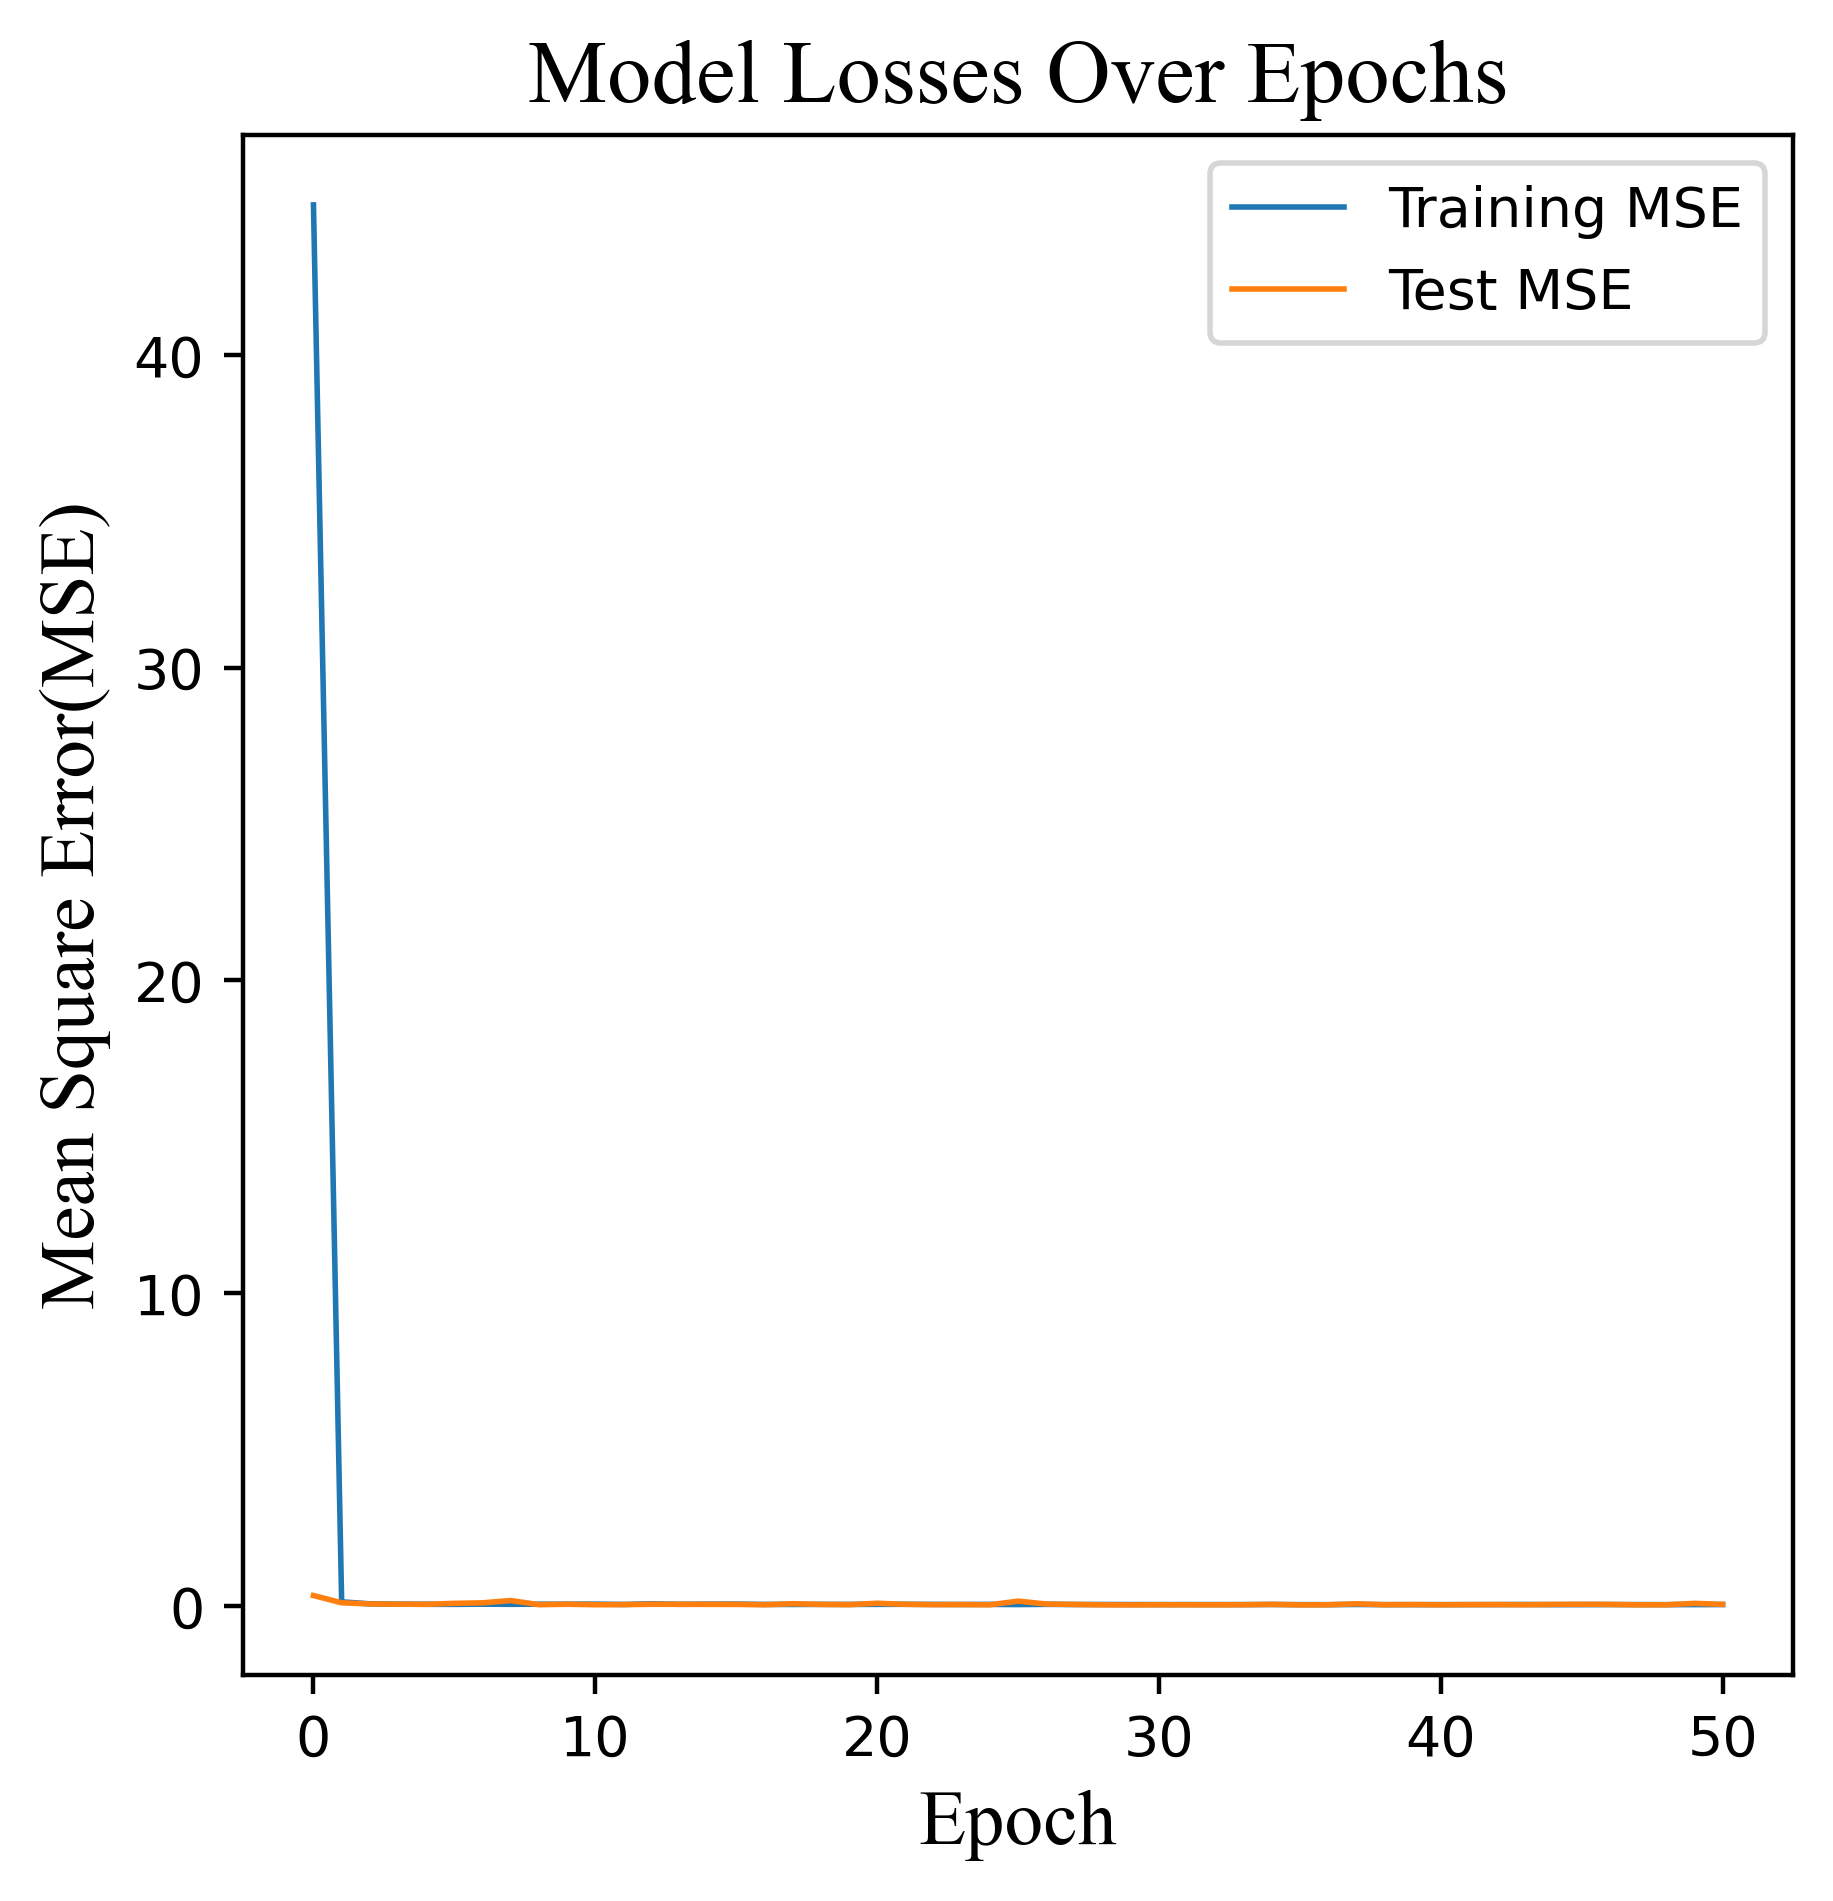

In [211]:
print(history.history['loss'])
dpi = 400  # dots per inch
width_inch = 2000 / dpi
height_inch = 2000 / dpi

plt.figure(figsize=(width_inch, height_inch), dpi=dpi)
plt.plot(history.history['loss'], label='Training MSE',lw = 1,)
plt.plot(history.history['val_loss'], label='Test MSE', lw = 1,)
plt.title('Model Losses Over Epochs',fontname='Times New Roman', fontsize=16)
plt.ylabel('Mean Square Error(MSE)',fontname='Times New Roman', fontsize=14)
plt.xlabel('Epoch',fontname='Times New Roman', fontsize=14)
plt.legend()
plt.show()

## Predicting the Test Set Results

In [212]:
y_pred_test = ann.predict(X_test)
y_pred_train = ann.predict(X_train)

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
526/526 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


In [213]:
# print(y_pred)
results_df = pd.DataFrame({
    'True Values (y_test)': y_test,
    'Predicted Values (y_pred)': y_pred_test.flatten()
})

print(results_df)

       True Values (y_test)  Predicted Values (y_pred)
10942                  18.2                  18.029781
21473                  22.7                  22.592627
8334                   23.6                  23.447069
10725                  25.7                  25.423838
9178                   31.9                  31.951113
...                     ...                        ...
3938                   26.5                  26.508085
9146                   31.3                  31.274361
1550                   23.3                  23.296148
16915                  23.0                  22.950449
4489                   22.3                  22.320225

[4207 rows x 2 columns]


### Errors Measurement of Train Set

In [214]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
train_mse = mean_squared_error(y_train, y_pred_train)
train_mae = mean_absolute_error(y_train, y_pred_train)
train_mape = mean_absolute_percentage_error(y_train, y_pred_train)
train_r_squared = r2_score(y_train, y_pred_train)

print(f"\nMean Squared Error (MSE) of Train Set: {train_mse:.5f}")
print(f"Mean Absolute Error (MAE) of Train Set: {train_mae:.5f}")
print(f"Mean Absolute Percentage Error (MAPE) of Train Set: {train_mape:.5f}")
print(f"R-squared (R²) of Train Set: {train_r_squared:.5f}")


Mean Squared Error (MSE) of Train Set: 0.04921
Mean Absolute Error (MAE) of Train Set: 0.15106
Mean Absolute Percentage Error (MAPE) of Train Set: 0.00664
R-squared (R²) of Train Set: 0.99631


### Errors Measurement of Test Set

In [215]:
test_mse = mean_squared_error(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_mape = mean_absolute_percentage_error(y_test, y_pred_test)
test_r_squared = r2_score(y_test, y_pred_test)

print(f"\nMean Squared Error (MSE) of Test Set: {test_mse:.5f}")
print(f"Mean Absolute Error (MAE) of Test Set: {test_mae:.5f}")
print(f"Mean Absolute Percentage Error (MAPE) of Test Set: {test_mape:.5f}")
print(f"R-squared (R²) of Test Set: {test_r_squared:.5f}")


Mean Squared Error (MSE) of Test Set: 0.05115
Mean Absolute Error (MAE) of Test Set: 0.15176
Mean Absolute Percentage Error (MAPE) of Test Set: 0.00667
R-squared (R²) of Test Set: 0.99619


### Model Evaluation

In [216]:
# Printing MSE for Training and Test Sets
print(f"\nTraining Set - Mean Squared Error (ANN MSE): {train_mse:.5f}")
print(f"Test Set - Mean Squared Error (ANN MSE): {test_mse:.5f}\n")

# Commenting on Model Fit based on MSE
if abs(train_mse - test_mse) < 0.01:  # Threshold for MSE difference between train and test
    print("ANN Model has a Good Fit.")
elif test_mse > train_mse:
    print("ANN Model is Overfitting.")
else:
    print("ANN Model is Underfitting.")



Training Set - Mean Squared Error (ANN MSE): 0.04921
Test Set - Mean Squared Error (ANN MSE): 0.05115

ANN Model has a Good Fit.


### Plotting

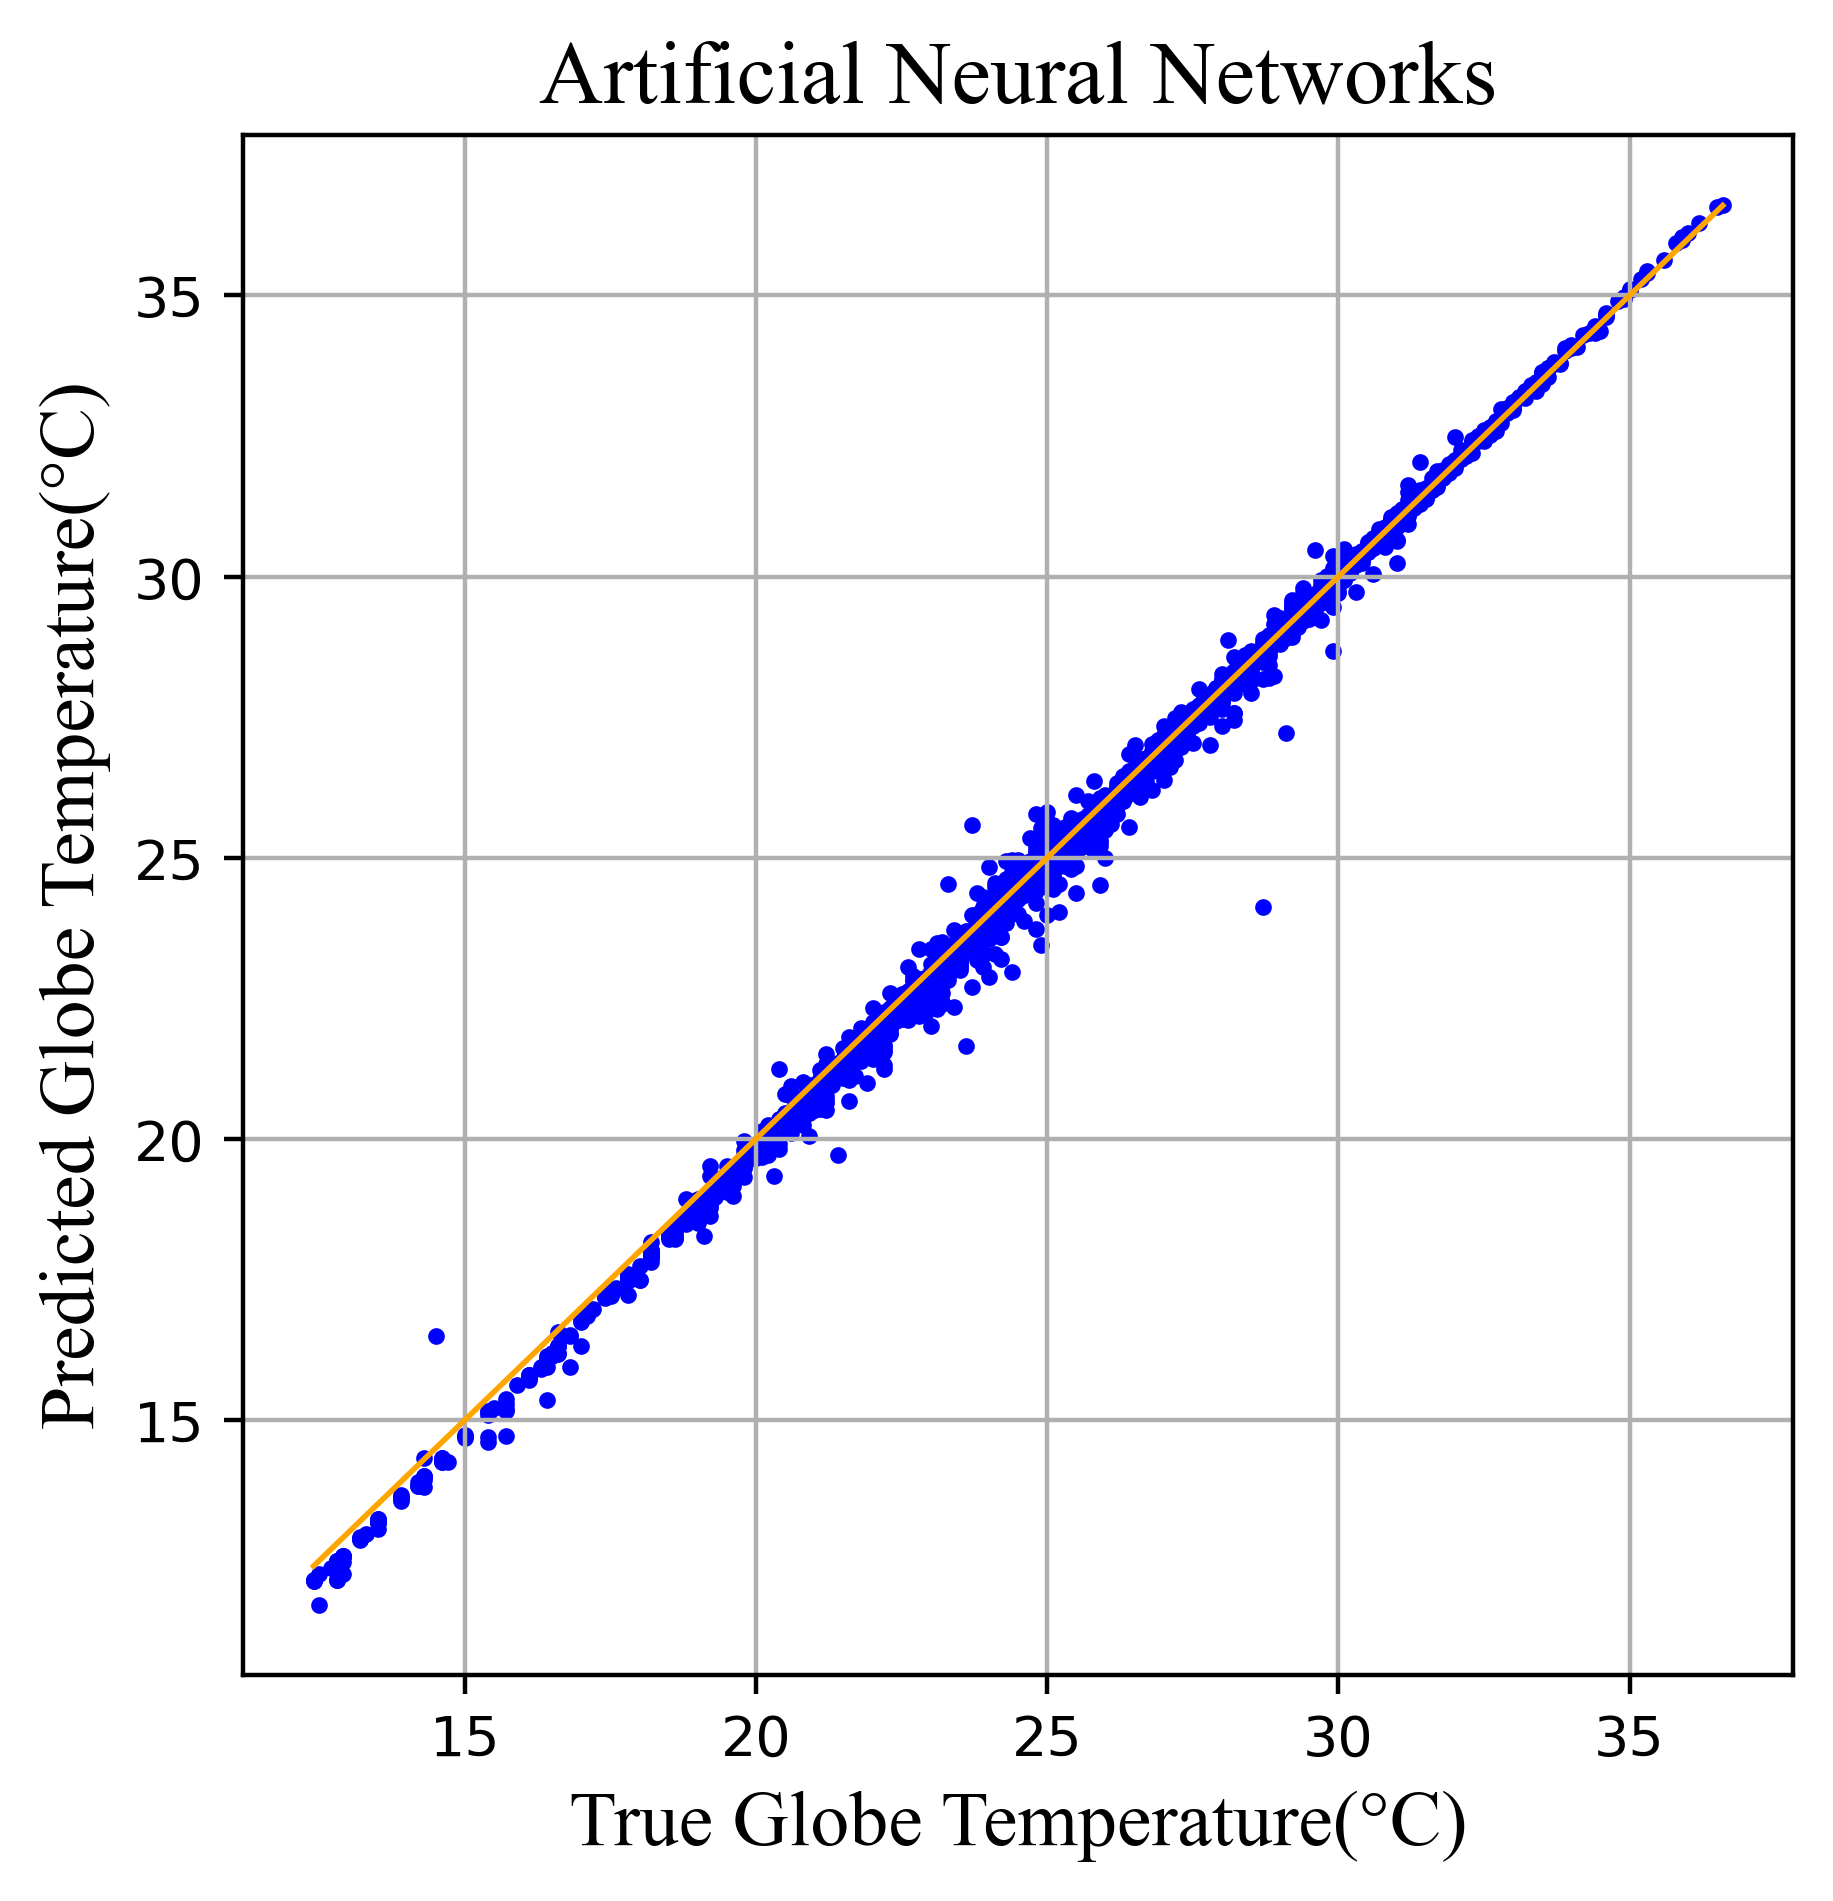

In [217]:
dpi = 400  # dots per inch
width_inch = 2000 / dpi
height_inch = 2000 / dpi

plt.figure(figsize=(width_inch, height_inch), dpi=dpi)
plt.scatter(y_test, y_pred_test, color='blue',s=4)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='orange', lw=1)
plt.title('Artificial Neural Networks',fontname='Times New Roman', fontsize=16)
plt.xlabel('True Globe Temperature(°C)',fontname='Times New Roman', fontsize=14)
plt.ylabel('Predicted Globe Temperature(°C)',fontname='Times New Roman', fontsize=14)
plt.grid(True)
plt.show()

### Features Importance

Epoch 1/10
526/526 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - loss: 0.0347 - mean_absolute_error: 0.1188 - mean_absolute_percentage_error: 0.4908
Epoch 2/10
526/526 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - loss: 0.0474 - mean_absolute_error: 0.1321 - mean_absolute_percentage_error: 0.5434
Epoch 3/10
526/526 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - loss: 0.0429 - mean_absolute_error: 0.1298 - mean_absolute_percentage_error: 0.5345
Epoch 4/10
526/526 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - loss: 0.0404 - mean_absolute_error: 0.1324 - mean_absolute_percentage_error: 0.5469
Epoch 5/10
526/526 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 0.0466 - mean_absolute_error: 0.1310 - mean_absolute_percentage_error: 0.5427
Epoch 6/10
526/526 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 0.0544 - mean_absolute_error: 0.1345 - mean_absolute_percentage_error: 0.5561
Epoch 7/10
526/526 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 0.0390 - mean_absolute_error: 0.1260 - mean_absolute_percentage_error: 0.5183
Epoch 8/10
526/526 ━

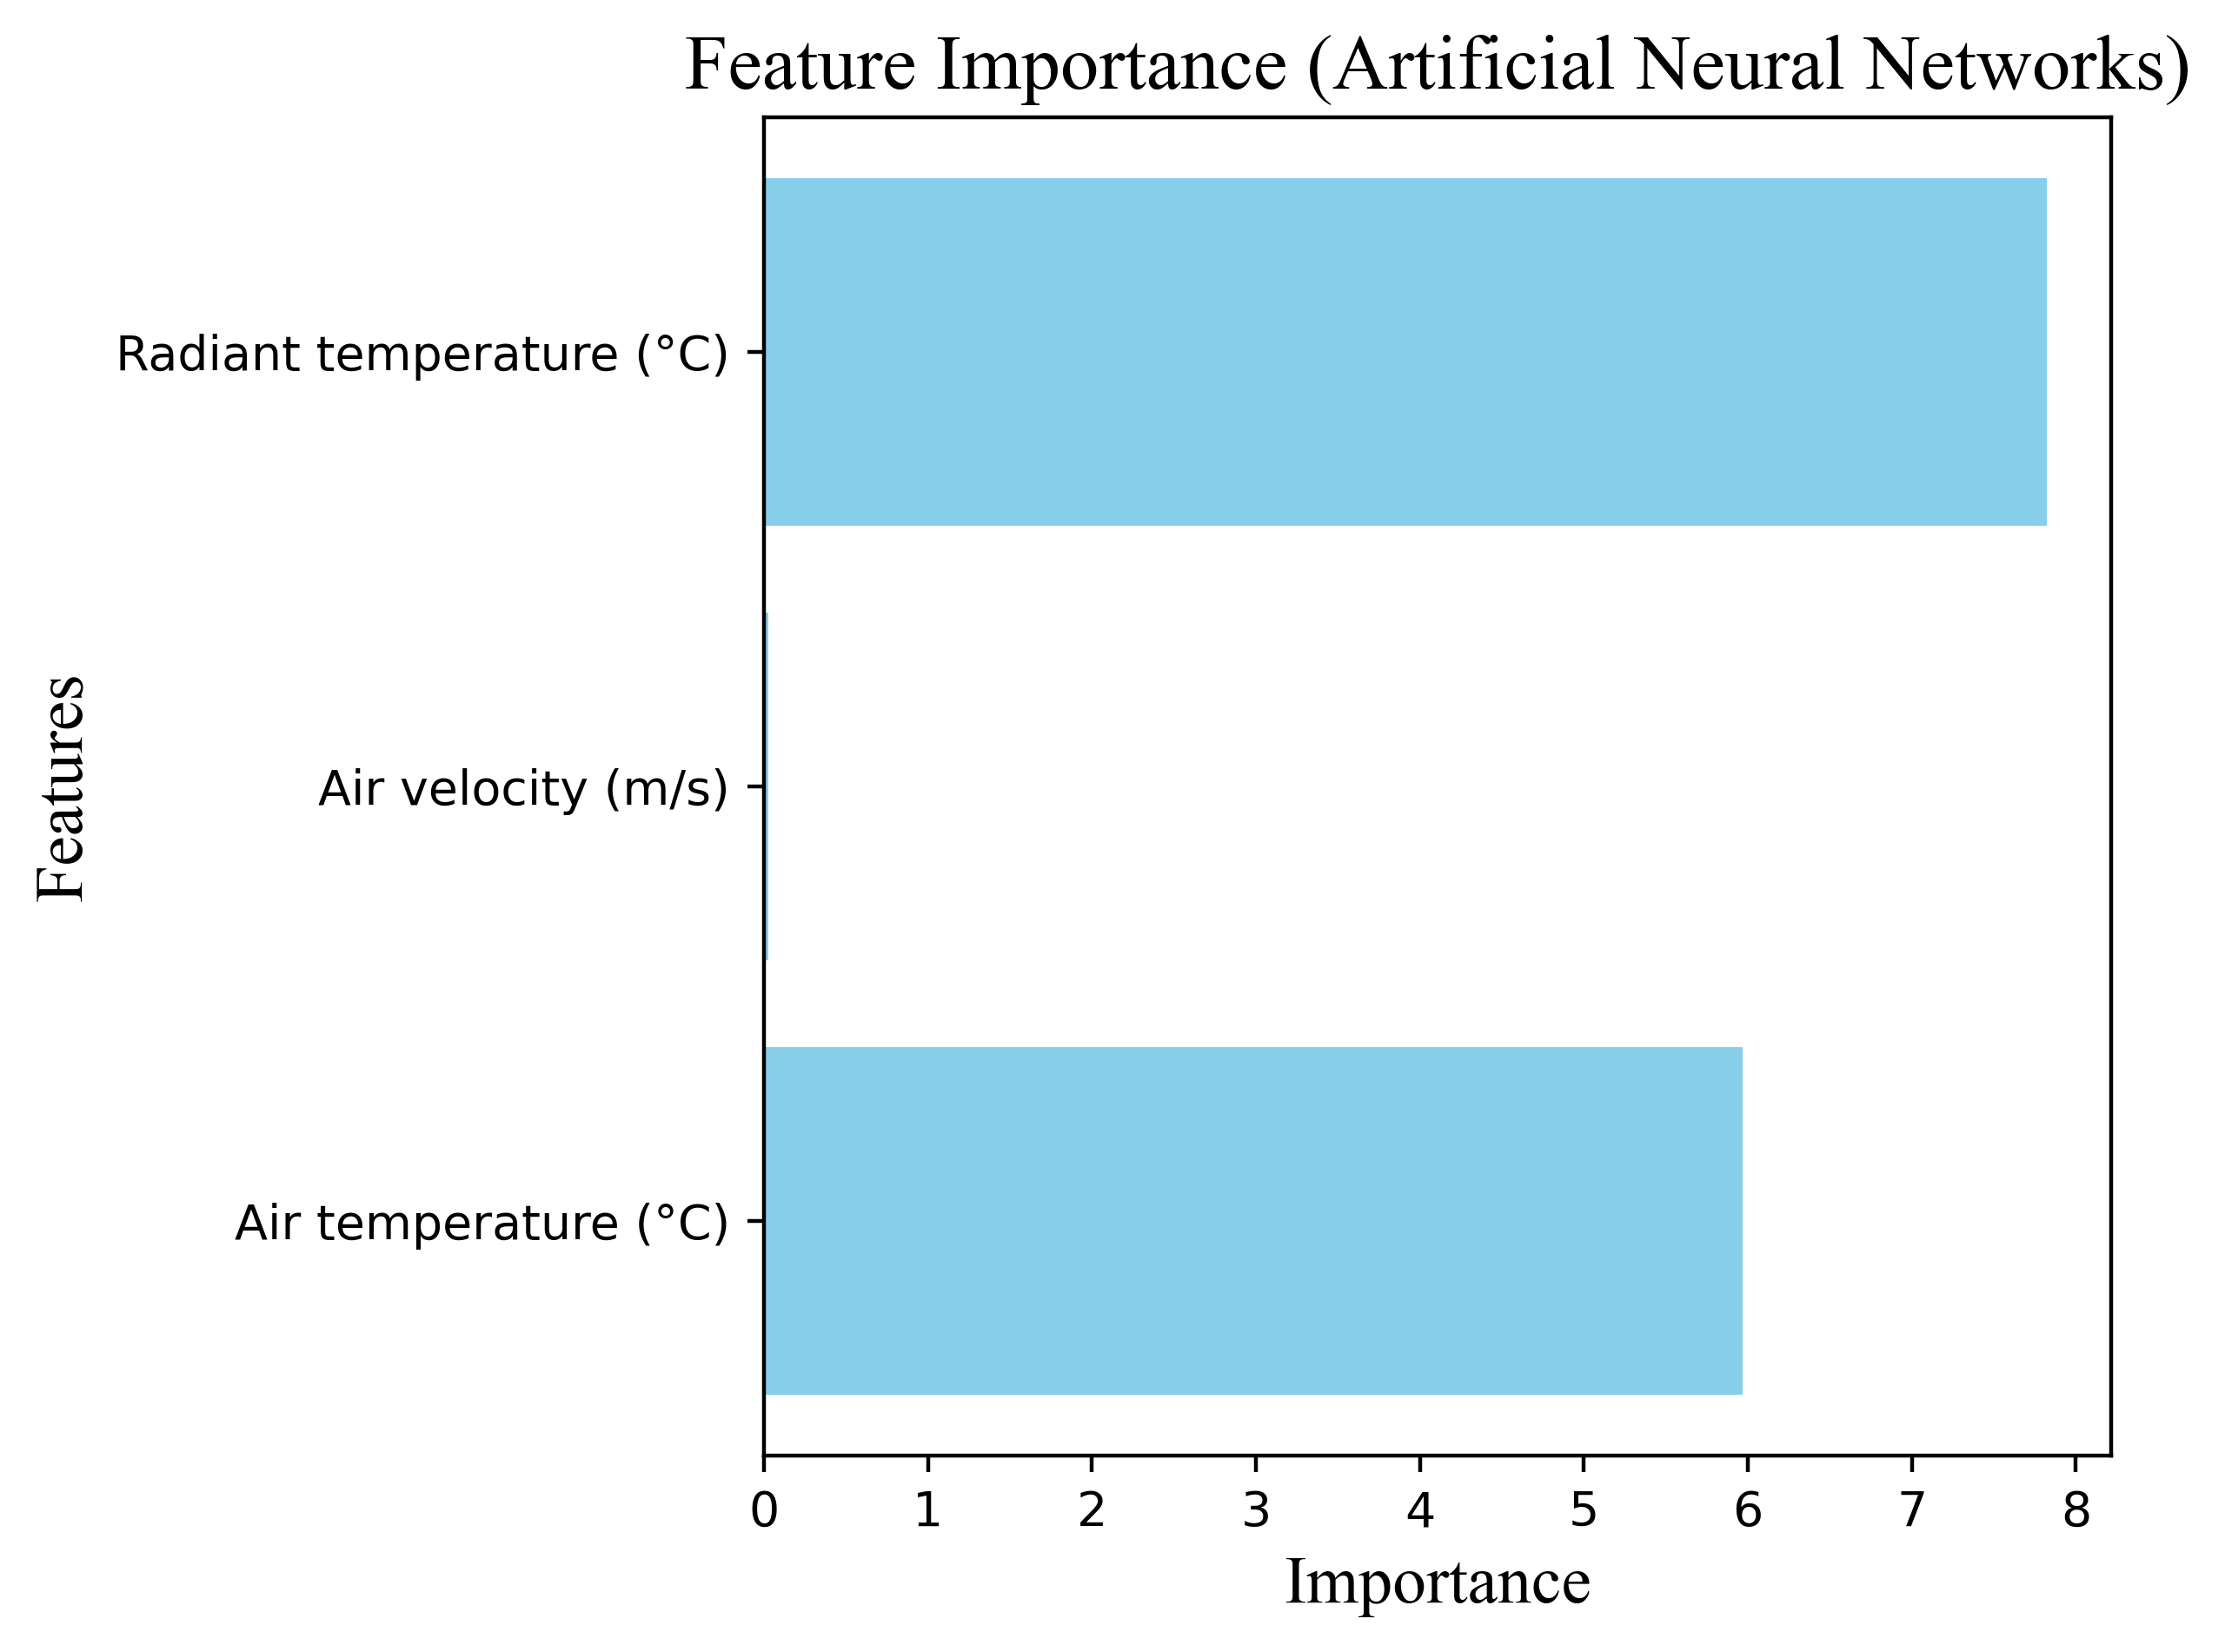

In [218]:
# Compute permutation importance
from sklearn.inspection import permutation_importance
class ANNWrapper:
    def __init__(self, model):
        self.model = model

    def fit(self, x, y):
        self.model.fit(x, y, epochs=10, batch_size=32, verbose=1)

    def predict(self, x):
        return self.model.predict(x).flatten()

# Wrap the ANN model
ann_wrapper = ANNWrapper(ann)
ann_wrapper.fit(X_train, y_train)

result = permutation_importance(ann_wrapper, X_test, y_test, n_repeats=10, random_state=0, scoring='neg_mean_squared_error')

# Plot feature importance
importance = result.importances_mean
feature_names = X.columns

# Sort the feature importance values by feature name for consistency
sorted_indices = np.argsort(feature_names)  # Sort by feature names alphabetically
sorted_feature_names = feature_names[sorted_indices]
sorted_importance = importance[sorted_indices]

dpi = 400  # dots per inch
width_inch = 2000 / dpi
height_inch = 2000 / dpi

plt.figure(figsize=(width_inch, height_inch), dpi=dpi)
plt.barh(sorted_feature_names, sorted_importance, color='skyblue')
plt.xlabel('Importance', fontname='Times New Roman', fontsize=14)
plt.ylabel('Features', fontname='Times New Roman', fontsize=14)
plt.title('Feature Importance (Artificial Neural Networks)', fontname='Times New Roman', fontsize=16)
plt.show()


### Save the Trained Model

In [219]:
#ann.save('mrt_prediction_ann.keras')

### Load the Trained Model

In [220]:
#from keras import load_model
#model = load_model('mrt_prediction_ann.keras')  # Load the model

#y = model.predict(X_test)
#print(y)